In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measures = Base.classes.measurement
station_data = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
session

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
recent_date_data = session.query(func.max(measures.date)).first()
print(recent_date_data)

('2017-08-23',)


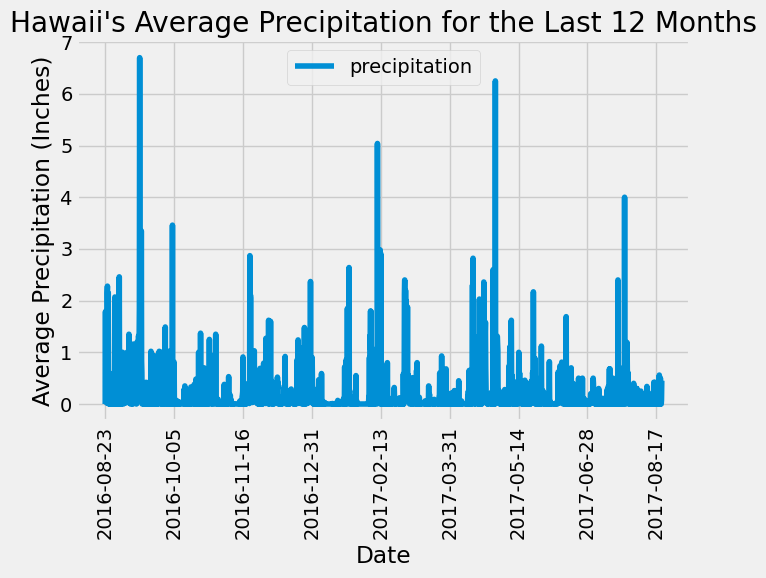

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_str = recent_date_data[0]
recent_date = dt.datetime.strptime(recent_date_str, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.- I used 366 days in order to include 2016-08-23
year_before = recent_date - dt.timedelta(days = 366)
# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(measures).\
    filter(measures.date > year_before)

# Selecting only the date and prcp values for data
data = [(measure.date, measure.prcp) for measure in prec_data]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_df = pd.DataFrame(data, columns = ['date', 'precipitation'])
prec_df.set_index('date', inplace=True)

# Sort the dataframe by date
prec_df_sorted = prec_df.sort_values(by = 'date', ascending = True)

# Drop null values
prec_df_sorted.dropna(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
prec_df_sorted.plot(kind='line', figsize=(7, 6))
plt.title("Hawaii's Average Precipitation for the Last 12 Months")
plt.xlabel('Date')
plt.ylabel('Average Precipitation (Inches)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();


In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = prec_df_sorted.describe()
sum_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station_data.station.distinct())).all()
total_stations

[(9,)]

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measures.station, func.count(measures.station)).\
    group_by(measures.station).\
    order_by(func.count(measures.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(measures.station, func.count(measures.station)).\
    group_by(measures.station).\
    order_by(func.count(measures.station).desc()).first()[0]

# Calculating stats for tobs
stats = [func.min(measures.tobs),
         func.max(measures.tobs),
         func.avg(measures.tobs)]
most_active_stats = session.query(*stats).\
    filter(measures.station == most_active).all()

most_active_stats

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Find the most recent date from the most active station (found above)
most_tobs_recent_date = session.query(measures.date).\
    filter(measures.station == most_active).\
    order_by(measures.date.desc()).first()[0]
most_tobs_recent_date

'2017-08-18'

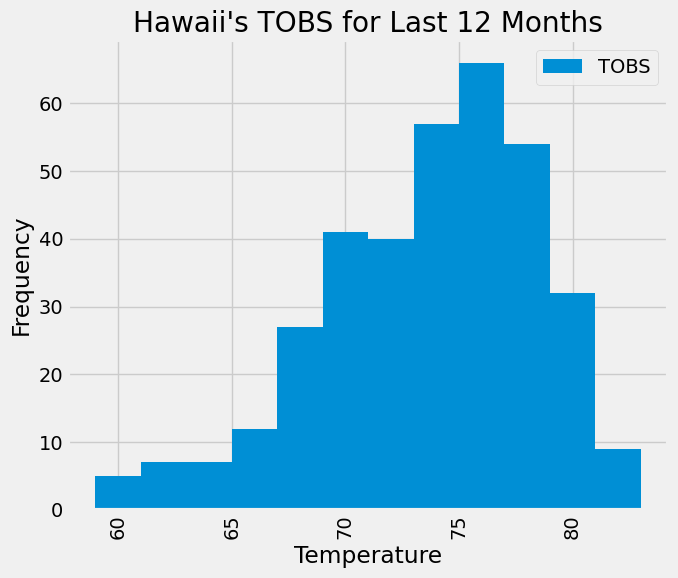

In [33]:
# Design a query to retrieve the last 12 months of TOBS data and plot the results. 
# Starting from the most recent data point in the database. 
recent_tobs_date_str = most_tobs_recent_date

recent_tobs_date = dt.datetime.strptime(recent_tobs_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago = recent_tobs_date - dt.timedelta(days = 366)

# Perform a query to retrieve the data and tobs scores
most_tobs_data = session.query(measures.date, measures.tobs).\
    filter(measures.station == most_active, measures.date >= year_ago).all()

# Selecting only the date and tobs values for data
data = [(measure.date, measure.tobs) for measure in most_tobs_data]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(data, columns = ['date', 'temperature'])
tobs_df.set_index('date', inplace=True)

# Drop null values
tobs_df.dropna(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
tobs_df.plot(kind='hist', figsize=(7, 6), bins=12)
plt.title("Hawaii's TOBS for Last 12 Months")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['TOBS'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();


# Close Session

In [34]:
# Close Session
session.close()